In [2]:
import numpy as np
import matplotlib.pyplot as plt
import tifffile
import os
import random
from scipy import ndimage
import geopandas as gpd
# import rasterio
import regionmask

ModuleNotFoundError: No module named 'numpy'

In [ ]:
# Load tiff stack images and masks

#165 large images as tiff image stack
# fp = r'f:\DB\ITC\quebec_trees_dataset_2021-05-28\quebec_trees_dataset_2021-05-28\2021-05-28\zone1\2021-05-28-sbl-z1-rgb-cog.tif'
# fp = r'f:\DB\ITC\Training_Dataset\Canada_Dataset\images\2021-09-02-sbl-z1-rgb-cog_10203_11126_None.png'
# large_images = tifffile.imread(fp)
# large_images = tifffile.imread("f:/DB/ITC/Training_Dataset/Canada_Dataset/images/2021-09-02-sbl-z1-rgb-cog_10203_11126_None.png")
# large_masks = tifffile.imread("/content/drive/MyDrive/ColabNotebooks/data/mitochondria/full_dataset/masks/mitochondria_train_masks_01.tif")


import matplotlib.pyplot as plt

fp = r'..\Training_Dataset\Canada_Dataset\images\2021-09-02-sbl-z1-rgb-cog_10203_11126_None.png'
large_images = plt.imread(fp)

fp = r'..\Training_Dataset\Canada_Dataset\images\2021-09-02-sbl-z1-rgb-cog_10203_12049_None.png'
large_images_2 = plt.imread(fp)

fp = r'..\Training_Dataset\Canada_Dataset\images\2021-09-02-sbl-z1-rgb-cog_10203_12972_None.png'
large_images_3 = plt.imread(fp)

# give me the variable file_name which is the name of the .png file between quotes
file_name = str(os.path.basename(fp))
print(file_name)

: 

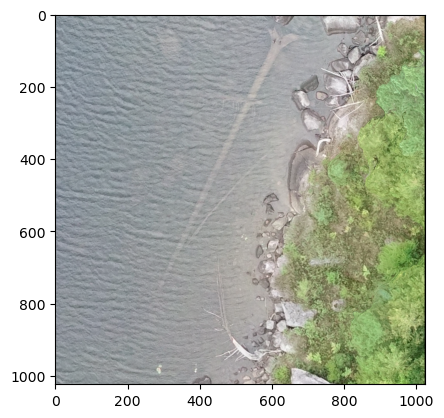

In [ ]:
# Display the image
plt.imshow(large_images)
plt.show()

In [ ]:
large_images.shape[0]

1024

In [ ]:
import json
from shapely.geometry import Polygon

fp = r'f:\DB\ITC\Training_Dataset\Canada_Dataset\annotations\Quebec_train.json'

# Load JSON file
with open(fp) as f:
    data = json.load(f)

# Create a mapping from image_id to file_name
id_to_filename = {image['id']: image['file_name'] for image in data['images']}

# Extract polygons with corresponding image IDs and bounding boxes
polygons = []
for annotation in data['annotations']:
    for segmentation in annotation['segmentation']:
        # Each segmentation is a list of points (x, y)
        polygon = Polygon([(segmentation[i], segmentation[i+1]) for i in range(0, len(segmentation), 2)])
        polygons.append({
            'image_id': annotation['image_id'], 
            'file_name': id_to_filename.get(annotation['image_id'], ''),  # Include the file name
            'polygon': polygon, 
            'bbox': annotation['bbox']  # Include the bounding box
        })  

In [ ]:
polygons[0]

{'image_id': 0,
 'file_name': '2021-09-02-sbl-z1-rgb-cog_10203_11126_None.png',
 'polygon': <POLYGON ((866.164 1021.756, 866.164 1017.606, 868.006 1016.217, 893.941 101...>,
 'bbox': [866.1635, 993.5985, 117.1146, 29.4015]}

In [ ]:
# Get all polygons for image 0
polygons_image_0 = [p['polygon'] for p in polygons if p['file_name'] == file_name]
bbox_image_0 = [p['bbox'] for p in polygons if p['file_name'] == file_name]

<Axes: >

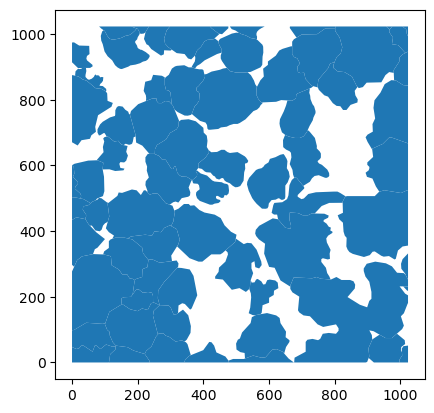

In [ ]:
# polygons_image_0 into geopandas
gdf = gpd.GeoDataFrame(geometry=polygons_image_0)
gdf.plot()

In [ ]:
# Convert bbox to geometry (rectangles) and store in a geodataframe
gdf_bbox = gpd.GeoDataFrame(geometry=[Polygon([(bbox[0], bbox[1]), (bbox[0] + bbox[2], bbox[1]), (bbox[0] + bbox[2], bbox[1] + bbox[3]), (bbox[0], bbox[1] + bbox[3])]) for bbox in bbox_image_0])
# Add rows to the main gdf
gdf['bbox'] = gdf_bbox.geometry

<Axes: >

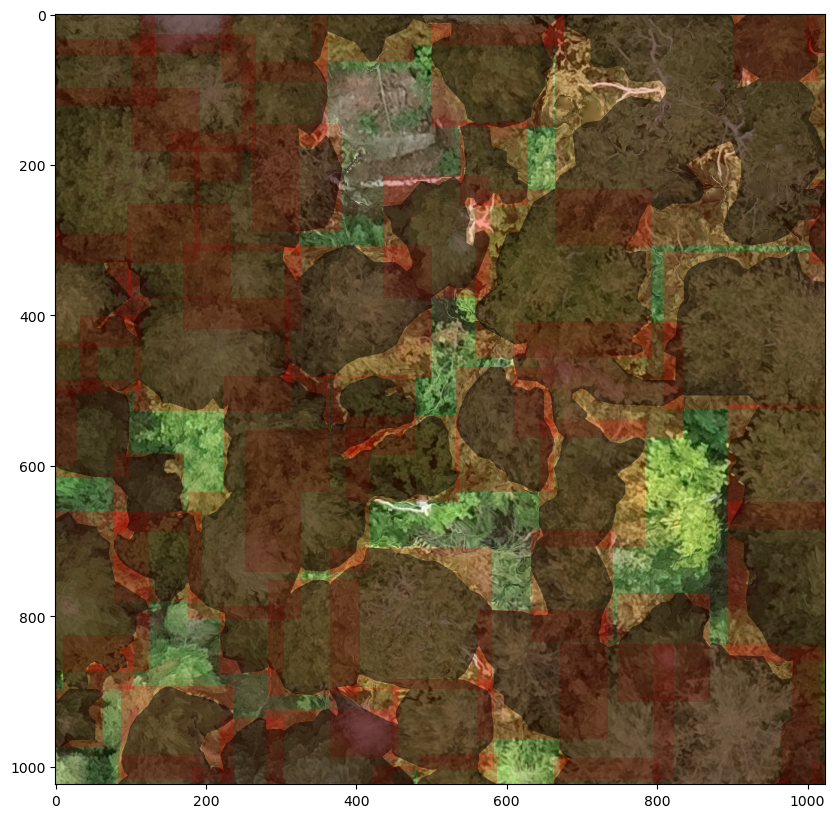

In [ ]:
# plot the image with the polygons
fig, ax = plt.subplots(figsize=(10, 10))
ax.imshow(large_images_3)

# plot gdf polygons on top of the image
# plot bboxes as transparent rectangles
gdf['bbox'].plot(ax=ax, color='red', alpha=0.2)
gdf['geometry'].plot(ax=ax, color='black', alpha=0.5)


In [ ]:
# # Mask out the polygons from the large_images_3
# # First create a binary mask

# import regionmask

# # Generate x and y coordinates
# x = np.arange(0, large_images_3.shape[1], step=1.)
# y = np.arange(0, large_images_3.shape[0], step=1.)

# # Create mask
# mask = regionmask.mask_geopandas(gdf, x, y)

# ## If you want to merg all polygons to 1 mask add this before the the mask command:
# # gdf = gdf.dissolve()

In [ ]:
import rasterio
from rasterio.features import rasterize
from shapely.geometry import mapping

# Define the transformation
transform = rasterio.transform.from_origin(0, 1024, 1, 1)

# Define the shape of the output array (1024 x 1024)
out_shape = (1024, 1024)

# Convert the GeoDataFrame geometry to the format rasterize expects
## Adding disolve to merge all polygons to 1 mask, Remove if you want to keep all polygons
gdf_dissolved = gdf.dissolve()
gdf_dissolved['mask_idx'] = gdf_dissolved.index + 1 # (0 is reserved for background)
# Add one row with the "background"the non--polygon space
shapes = ((mapping(geom), value) for geom, value in zip(gdf_dissolved['geometry'], gdf_dissolved['mask_idx']))

# Create the mask - all trees or background
mask_all_trees = rasterize(shapes, out_shape=out_shape, transform=transform)

# Repeat - but for individiaul trees
gdf['mask_idx'] = gdf.index + 1 # (0 is reserved for background)
shapes = ((mapping(geom), value) for geom, value in zip(gdf['geometry'], gdf['mask_idx']))
mask_individual_trees = rasterize(shapes, out_shape=out_shape, transform=transform)


# Possible convert your BBOXes to binary masks as well


# The mask is a 2D numpy array with the same shape as the output array. 
# The value at each pixel is the index of the polygon that pixel is in, or 0 if the pixel is not in any polygon.

In [ ]:
# Here start looping through each tree/object in your gdf
#   Find the corresponding json location
#   Mask - mask_individual_trees
#       sort of make new mask, only for THIS tree
#            Copy the mask array, and set all pixels expect the ones for this trees mask index to 0, and all of this tree to 1
#            single_tree_mask = mask.copy()
#            single_tree_mask = np.where(single_tree_mask == mask_index, 1, 0)
#            Add mask (np.array of shape (1024,1024,1))
#    Bounding - basically the same - repeat steps above :) 

In [ ]:
mask_individual_trees[1]

array([ 0,  0,  0, ..., 45, 45,  0], dtype=uint8)

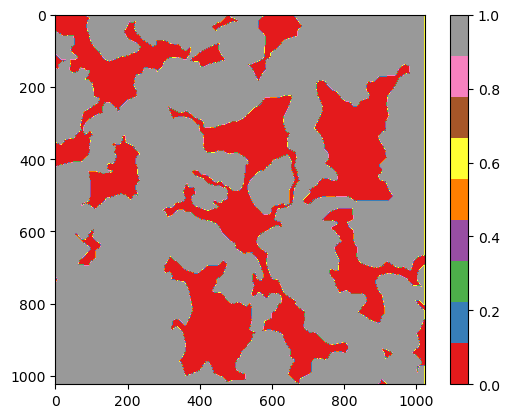

In [ ]:
import matplotlib.pyplot as plt

# Plot the mask
plt.imshow(mask_all_trees, cmap='Set1')
# plt legend
plt.colorbar()
plt.show() #44 seconds

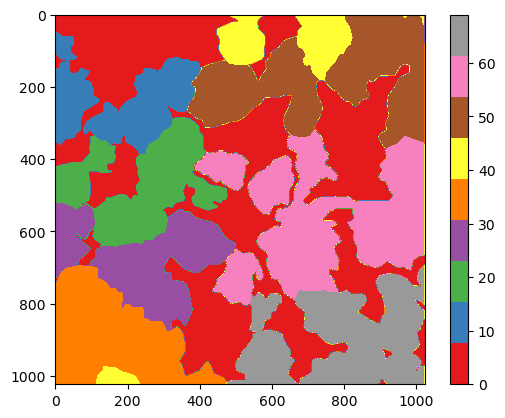

In [ ]:
import matplotlib.pyplot as plt

# Plot the mask
plt.imshow(mask_individual_trees, cmap='Set1')
# plt legend
plt.colorbar()
plt.show() #44 seconds

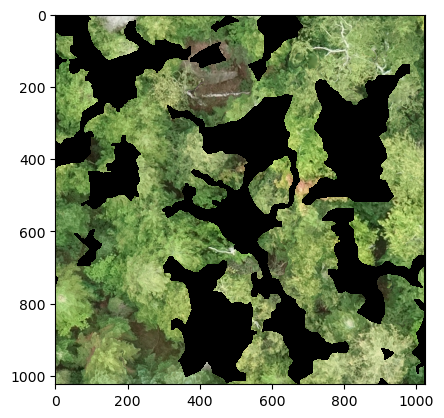

In [ ]:
# DO actual masking
masked_img_tree_or_no_tree = np.where(mask_all_trees[:,:,np.newaxis] == 1, large_images_3, np.nan)
masked_img_tree_or_no_tree.shape
# Plot the masked image
plt.imshow(masked_img_tree_or_no_tree)

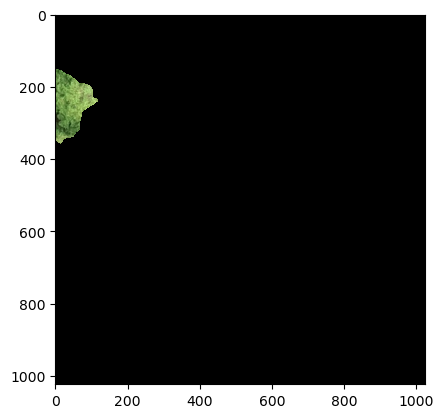

In [ ]:
# DO actual masking
for tree in np.unique(mask_individual_trees)[13:14]:
    if tree == 0: # skip background
        continue
    masked_img_individual_tree = np.where(mask_individual_trees[:,:,np.newaxis] == tree, large_images_3, np.nan)
    plt.imshow(masked_img_individual_tree)
    plt.show()

In [ ]:
gdf

,geometry,bbox,mask_idx
0,"POLYGON ((426.118 1016.708, 446.244 1001.372, ...","POLYGON ((420.057 999.455, 475.960 999.455, 47...",1
1,"POLYGON ((89.322 1016.449, 96.013 1011.839, 99...","POLYGON ((82.486 983.422, 196.583 983.422, 196...",2
2,"POLYGON ((181.702 1022.459, 196.583 1016.972, ...","POLYGON ((181.702 1000.411, 233.978 1000.411, ...",3
3,"POLYGON ((288.091 1010.957, 280.423 986.036, 2...","POLYGON ((280.423 922.776, 449.534 922.776, 44...",4
4,"POLYGON ((223.875 1006.162, 223.632 1005.095, ...","POLYGON ((219.080 934.278, 304.187 934.278, 30...",5
...,...,...,...
64,"POLYGON ((1009.063 49.687, 1003.861 41.887, 10...","POLYGON ((996.891 0.000, 1023.000 0.000, 1023....",65
65,"POLYGON ((573.630 147.125, 577.395 150.891, 58...","POLYGON ((537.878 143.239, 628.198 143.239, 62...",66
66,"POLYGON ((898.570 1.594, 903.360 14.046, 905.0...","POLYGON ((664.594 0.000, 1023.000 0.000, 1023....",67
67,"POLYGON ((646.396 28.891, 651.592 47.089, 661....","POLYGON ((499.507 12.039, 661.990 12.039, 661....",68


In [ ]:
import geopandas as gpd
import rasterio
from rasterio.features import rasterize
from shapely.geometry import mapping

# Define the transformation
transform = rasterio.transform.from_origin(0, 1024, 1, 1)

# Define the shape of the output array (1024 x 1024)
out_shape = (1024, 1024)

# Initialize an empty dictionary to store the masks
masks = {}

# Get unique mask indices
mask_indices = gdf['mask_idx'].unique()

# Iterate over all mask indices
for mask_idx in mask_indices:
    # Filter the GeoDataFrame by mask_idx
    gdf_filtered = gdf[gdf['mask_idx'] == mask_idx]
    
    # Dissolve all polygons into a single polygon
    gdf_dissolved = gdf_filtered.dissolve()
    gdf_dissolved['mask_idx'] = gdf_dissolved.index + 1  # (0 is reserved for background)

    # Convert the GeoDataFrame geometry to the format rasterize expects
    shapes = ((mapping(geom), value) for geom, value in zip(gdf_dissolved['geometry'], gdf_dissolved['mask_idx']))

    # Create the mask - all trees or background
    mask = rasterize(shapes, out_shape=out_shape, transform=transform)
    
    # Store the mask in the dictionary
    masks[mask_idx] = mask

In [ ]:
masks

{1: array([[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]], dtype=uint8),
 2: array([[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]], dtype=uint8),
 3: array([[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]], dtype=uint8),
 4: array([[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]], dtype=uint8),
 5: array([[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 

c:\Users\VegaB002\AppData\Local\anaconda3\envs\itc_delineation\Lib\site-packages\matplotlib\cm.py:494: RuntimeWarning: invalid value encountered in cast
  xx = (xx * 255).astype(np.uint8)


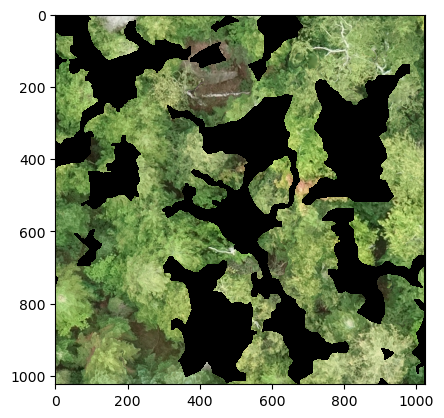

In [ ]:
import matplotlib.pyplot as plt
import json
from shapely.geometry import Polygon
import rasterio
from rasterio.features import rasterize
from shapely.geometry import mapping

fp = r'f:\DB\ITC\Training_Dataset\Canada_Dataset\images\2021-09-02-sbl-z1-rgb-cog_10203_11126_None.png'
large_images = plt.imread(fp)

fp = r'f:\DB\ITC\Training_Dataset\Canada_Dataset\annotations\Quebec_train.json'
with open(fp) as f:
    data = json.load(f)

# Create a mapping from image_id to file_name
id_to_filename = {image['id']: image['file_name'] for image in data['images']}

# Extract polygons with corresponding image IDs and bounding boxes
polygons = []
for annotation in data['annotations']:
    for segmentation in annotation['segmentation']:
        # Each segmentation is a list of points (x, y)
        polygon = Polygon([(segmentation[i], segmentation[i+1]) for i in range(0, len(segmentation), 2)])
        polygons.append({
            'image_id': annotation['image_id'], 
            'file_name': id_to_filename.get(annotation['image_id'], ''),  # Include the file name
            'polygon': polygon, 
            'bbox': annotation['bbox']  # Include the bounding box
        })

# Define the transformation
transform = rasterio.transform.from_origin(0, 1024, 1, 1)

# Define the shape of the output array (1024 x 1024)
out_shape = (1024, 1024)

# Convert the GeoDataFrame geometry to the format rasterize expects
## Adding disolve to merge all polygons to 1 mask, Remove if you want to keep all polygons
gdf_dissolved = gdf.dissolve()
gdf_dissolved['mask_idx'] = gdf_dissolved.index + 1 # (0 is reserved for background)
# Add one row with the "background"the non--polygon space
shapes = ((mapping(geom), value) for geom, value in zip(gdf_dissolved['geometry'], gdf_dissolved['mask_idx']))

# Create the mask - all trees or background
mask_all_trees = rasterize(shapes, out_shape=out_shape, transform=transform)


# Plot first mask per png
masked_img_tree_or_no_tree = np.where(mask_all_trees[:,:,np.newaxis] == 1, large_images_3, np.nan)
masked_img_tree_or_no_tree.shape
# Plot the masked image
plt.imshow(masked_img_tree_or_no_tree)

In [ ]:
# Initialize an empty dictionary to store the masks
masks = {}

# Iterate over all polygons
for polygon_info in polygons:
    # Get the image_id
    image_id = polygon_info['image_id']
    
    # If this image_id is not in the masks dictionary, add it
    if image_id not in masks:
        masks[image_id] = np.zeros(out_shape)
    
    # Convert the polygon to the format rasterize expects
    shapes = [(mapping(polygon_info['polygon']), 1)]
    
    # Create the mask for this polygon and add it to the existing mask for this image
    masks[image_id] += rasterize(shapes, out_shape=out_shape, transform=transform)

# Now masks is a dictionary where the keys are image_ids and the values are masks for all trees in that image

# Get the mask for the first image
first_image_id = list(masks.keys())[0]
first_mask = masks[first_image_id]

# Apply the mask to the image
masked_image = np.where(first_mask[:,:,np.newaxis] == 1, large_images, np.nan)

# Plot the masked image
plt.imshow(masked_image)


In [ ]:
# All masks in one array
masked_image

array([[[nan, nan, nan],
        [nan, nan, nan],
        [nan, nan, nan],
        ...,
        [nan, nan, nan],
        [nan, nan, nan],
        [nan, nan, nan]],

       [[nan, nan, nan],
        [nan, nan, nan],
        [nan, nan, nan],
        ...,
        [nan, nan, nan],
        [nan, nan, nan],
        [nan, nan, nan]],

       [[nan, nan, nan],
        [nan, nan, nan],
        [nan, nan, nan],
        ...,
        [nan, nan, nan],
        [nan, nan, nan],
        [nan, nan, nan]],

       ...,

       [[nan, nan, nan],
        [nan, nan, nan],
        [nan, nan, nan],
        ...,
        [nan, nan, nan],
        [nan, nan, nan],
        [nan, nan, nan]],

       [[nan, nan, nan],
        [nan, nan, nan],
        [nan, nan, nan],
        ...,
        [nan, nan, nan],
        [nan, nan, nan],
        [nan, nan, nan]],

       [[nan, nan, nan],
        [nan, nan, nan],
        [nan, nan, nan],
        ...,
        [nan, nan, nan],
        [nan, nan, nan],
        [nan, nan, nan]]

In [18]:
import json
from shapely.geometry import Polygon

fp = r'f:\DB\ITC\Training_Dataset\Canada_Dataset\annotations\Quebec_train.json'

# Load JSON file
with open(fp) as f:
    data = json.load(f)

# Create a mapping from image_id to file_name
id_to_filename = {image['id']: image['file_name'] for image in data['images']}

# Extract polygons with corresponding image IDs and bounding boxes
polygons = []
for annotation in data['annotations']:
    for segmentation in annotation['segmentation']:
        # Each segmentation is a list of points (x, y)
        polygon = Polygon([(segmentation[i], segmentation[i+1]) for i in range(0, len(segmentation), 2)])
        polygons.append({
            'image_id': annotation['image_id'], 
            'file_name': id_to_filename.get(annotation['image_id'], ''),  # Include the file name
            'polygon': polygon, 
            'bbox': annotation['bbox']  # Include the bounding box
        })

# Initialize an empty dictionary to store the masks
masks = {}

# Iterate over all polygons
for polygon_info in polygons:
    # Get the image_id
    image_id = polygon_info['image_id']
    
    # If this image_id is not in the masks dictionary, add it
    if image_id not in masks:
        masks[image_id] = np.zeros(out_shape)
    
    # Convert the polygon to the format rasterize expects
    shapes = [(mapping(polygon_info['polygon']), 1)]
    
    # Create the mask for this polygon and add it to the existing mask for this image
    masks[image_id] += rasterize(shapes, out_shape=out_shape, transform=transform)

# Now masks is a dictionary where the keys are image_ids and the values are masks for all trees in that image

# Get the mask for the first image
first_image_id = list(masks.keys())[0]
first_mask = masks[first_image_id]

# Apply the mask to the image
masked_image = np.where(first_mask[:,:,np.newaxis] == 1, large_images, np.nan)

# Plot the masked image
plt.imshow(masked_image)

FileNotFoundError: [Errno 2] No such file or directory: 'f:\\DB\\ITC\\Training_Dataset\\Canada_Dataset\\annotations\\Quebec_train.json'